In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
sys.path.append(os.path.abspath(os.path.join('./scripts')))
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import os
import pickle
import pandas as pd
from collections import Counter
import librosa
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import backend as K
from jiwer import wer
import random


import mlflow

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# !ln -s ./drive/MyDrive/SST/data/ ./
# !ln -s ./drive/MyDrive/SST/scripts/* ./

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# !pip3 install jiwer


In [7]:
import helper


In [11]:
from data_generator import DataGenerator
from tokenizer import Tokenizer
from logspectrorgam import LogMelSpectrogram
from ctc_loss import CTC_loss
from model2 import simple_rnn_model, CNN_net, BidirectionalRNN2, cnn_rnn_model

### Defining hop_size for our audio features 

### Init CTC_loss class

In [12]:
frame_step = 256
ctc = CTC_loss(frame_step)

### Defination of preprocessing model

- This model uses LogMelSpectrogram to generate features of an audio data at run time
- We will use this model as a part of our speech to text models to convert audio data to log melspectrogram

In [13]:
def preprocessin_model(sample_rate, fft_size, frame_step, n_mels, mfcc=False):

    input_data = Input(name='input', shape=(None,), dtype="float32")
    featLayer = LogMelSpectrogram(
        fft_size=fft_size,
        hop_size=frame_step,
        n_mels=n_mels,
        
        sample_rate=sample_rate,
        f_min=0.0,
        
        f_max=int(sample_rate / 2),
    )(input_data)
    
    x = BatchNormalization(axis=2)(featLayer)
    model = Model(inputs=input_data, outputs=x, name="preprocessin_model")

    return model

### Model trainer function

In [15]:
def train(model_builder, 
          data_gen,
          batch_size = 32,
          epochs=20, 
          verbose=1,
          save_path="../models/model.h5",
          optimizer=SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
          ):    
              
    model = ctc.add_ctc_loss(model_builder)

    checkpointer = ModelCheckpoint(filepath=save_path, verbose=0)
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    print(model.summary())


    hist = model.fit_generator(generator=data_gen,
                               callbacks=[checkpointer],

                               epochs=epochs,
                               verbose=verbose, 
                               use_multiprocessing=False)
    return model

### Loading our audio data and translation data from pickle file

- audio_obj is a key value pair dict where the key is the file name of the audio and value is the audio data
- translation_obj is a key value pair dict where the key is the file name of the audio and value is the transcription 


#### The metadata is a pandas dataframe which holds meta data information for each audio

In [16]:

translation_obj = helper.read_obj("../data/translation_dict.pkl")
audio_obj = helper.read_obj("../data/audio_dict.pkl")
meta_data = helper.read_csv("../data/meta_data.csv")


file read as csv


#### Sorting the audios based on the duration using the metadata

In [17]:
sorted_metadata = meta_data.sort_values(by="duration")
labels = sorted_metadata['label'].to_list()
sorted_metadata

,translation,label,channel,sample_rate,duration
4133,እኛ ም እ ኮ ፉትቦል ን እንወዳ ለ ን,tr_3933_tr40034,1,8000,2.048
1476,አሸናፊ ፈጣን ተጨዋች ነው,tr_1541_tr16042,1,8000,2.048
408,እንስራ ው ተ ሸነቆረ,tr_10369_tr100091,1,8000,2.176
73,ጥያቄ ያችን ጆንያ ሙሉ ነው,tr_10067_tr098029,1,8000,2.176
3574,ኳስ ጨዋታ ኳስ ነው,tr_342_tr04042,1,8000,2.176
...,...,...,...,...,...
2614,በ አውሮፕላኗ ተመትቶ መውደቅ ሳቢያ ዜጐቻቸው ን ላ ጡት የ ብሪታኒያ ና ...,tr_2566_tr26067,1,8000,20.352
1652,ሁሴን አይዲድ እንደ ገለጹት ኢትዮጵያ ሁኔታዎች ከ ተመቻቹ ላት ሶማሊያ ን...,tr_16_tr01016,1,8000,20.736
2222,ከ ግዛታቸው ዋ ና ከተማ ጋሪ ስ ሆነው በ ስልክ ሚስተር ሞሪስ ከ ስደተኞ...,tr_2212_tr23013,1,8000,20.992
2608,የተ ለቀቁት ምርኮኞች በ አካባቢያቸው ሰላማዊ ኑሮ እንዲ ኖሩ የ ትራንስፖ...,tr_2560_tr26061,1,8000,21.120


#### extracting audios and translations in lists

In [18]:
audios = []
for label in labels:
    audios.append(audio_obj[label][0])
    
translations = []
for label in labels:
    translations.append(translation_obj[label])

### Build function

- Build function takes a speech model and a preprocessing model (a model that gives melespectrogram features) and build them into a single speech model

In [19]:
def build_model(output_dim, custom_model, preprocess_model, mfcc=False, calc=None):

    input_audios = Input(name='the_input', shape=(None,))
    pre = preprocess_model(input_audios)
    pre = tf.squeeze(pre, [3])

    y_pred = custom_model(pre)
    model = Model(inputs=input_audios, outputs=y_pred, name="model_builder")
    model.output_length = calc

    return model

### Predict function

In [20]:
def predict(model, audio, tokenizer, int_to_char, actual=None):
    
    pred_audios = tf.convert_to_tensor([audio])
    
    y_pred = model.predict(pred_audios)

    input_shape = tf.keras.backend.shape(y_pred)
    input_length = tf.ones(shape=input_shape[0]) * tf.keras.backend.cast(input_shape[1], 'float32')
    prediction = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=False)[0][0]
        
    pred = K.eval(prediction).flatten().tolist()
    pred = [i for i in pred if i != -1]
    
    predicted_text = tokenizer.decode_text(pred, int_to_char)
    
    error = None
    if actual != None:
        error = wer(actual, predicted_text)
   
    return predicted_text, error

### Init our translation tokenizer and build a charchter mapping dict

In [21]:
tokenizer = Tokenizer(translations)
int_to_char, char_to_int = tokenizer.build_dict()
sample = translations[0]
encoded = tokenizer.encode(sample, char_to_int)
decoded = tokenizer.decode_text(encoded, int_to_char)

print(f"sample snt: {sample}")
print(f"encoded snt: {encoded}")
print(f"decoed snt: {decoded}")

sample snt: እኛ ም እ ኮ ፉትቦል ን እንወዳ ለ ን
encoded snt: [13, 74, 1, 16, 1, 13, 1, 67, 1, 142, 3, 122, 12, 1, 2, 1, 13, 2, 37, 39, 1, 11, 1, 2]
decoed snt: እኛ ም እ ኮ ፉትቦል ን እንወዳ ለ ን


In [22]:
helper.write_obj("../int_to_char.pkl", int_to_char)
helper.write_obj("../char_to_int.pkl", char_to_int)

### init our variables

In [23]:

sample_rate = 8000
fft_size = 512
frame_step = 256
n_mels = 128

batch_size = 100
epochs = 20
data_len = len(translations)
output_dim = len(char_to_int) + 2


### Init our DataGenerator and build our preprocessing model

In [24]:
dg = DataGenerator(translations, audios, batch_size, shuffle=True)
preprocess_model = preprocessin_model(sample_rate, fft_size, frame_step, n_mels)
preprocess_model.summary()

Model: "preprocessin_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None)]            0         
                                                                 
 log_mel_spectrogram (LogMel  (None, None, 128, 1)     0         
 Spectrogram)                                                    
                                                                 
 batch_normalization (BatchN  (None, None, 128, 1)     512       
 ormalization)                                                   
                                                                 
Total params: 512
Trainable params: 256
Non-trainable params: 256
_________________________________________________________________


### checking log melespectorgram of sample audio data using our preprocessing model

In [29]:
import librosa.display

(1, 49152)


(1, 191, 128, 1)

char_len 82


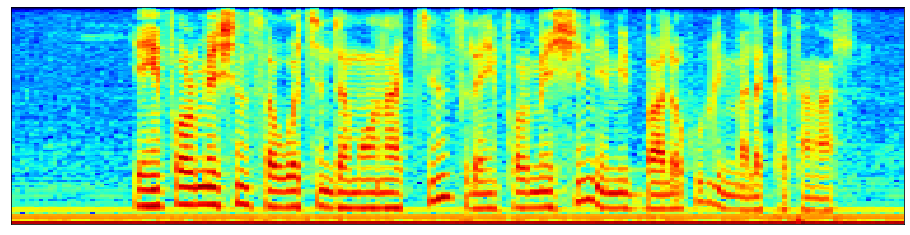

In [30]:
import librosa
sample_audio = dg[0][0]['the_input'][0].numpy()
sample_lbl = dg[0][0]['the_labels'][0].numpy()

a = np.zeros((1, len(sample_audio)))
a[0, ] = sample_audio
print(a.shape)
pred = preprocess_model.predict(a)
fig, ax = plt.subplots(figsize=(16, 4))
display(pred.shape)
pred = pred[0, :, :, 0]
librosa.display.specshow(pred.T, sr=8000, hop_length=128, cmap="jet")
print("char_len", len(sample_lbl))

(1, 97280)


(1, 379, 128, 1)

char_len 139


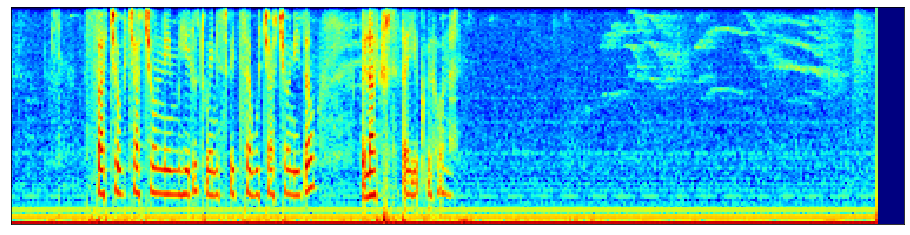

In [31]:

sample_audio = dg[49][0]['the_input'][-1].numpy()
sample_lbl = dg[49][0]['the_labels'][-1].numpy()

a = np.zeros((1, len(sample_audio)))
a[0, ] = sample_audio
print(a.shape)
pred = preprocess_model.predict(a)
fig, ax = plt.subplots(figsize=(16, 4))
display(pred.shape)
pred = pred[0, :, :, 0]
librosa.display.specshow(pred.T, sr=8000, hop_length=128, cmap="jet")
print("char_len", len(sample_lbl))

### 1. Simple RNN model for speech to text

#### creating a simple rnn model

In [32]:
speech_simple_rnn = simple_rnn_model(n_mels, output_dim)
speech_simple_rnn.summary()

Model: "simple_rnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None, 128)]       0         
                                                                 
 rnn (GRU)                   (None, None, 223)         236157    
                                                                 
 softmax (Activation)        (None, None, 223)         0         
                                                                 
Total params: 236,157
Trainable params: 236,157
Non-trainable params: 0
_________________________________________________________________


#### Building a simple rnn moel by stacking preprocessin_model and speech_simple_rnn

In [33]:
simple_rnn_speech_model = build_model(output_dim, speech_simple_rnn, preprocess_model)
simple_rnn_speech_model.summary()

Model: "model_builder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None)]            0         
                                                                 
 preprocessin_model (Functio  (None, None, 128, 1)     512       
 nal)                                                            
                                                                 
 tf.compat.v1.squeeze (TFOpL  (None, None, 128)        0         
 ambda)                                                          
                                                                 
 simple_rnn_model (Functiona  (None, None, 223)        236157    
 l)                                                              
                                                                 
Total params: 236,669
Trainable params: 236,413
Non-trainable params: 256
_____________________________________________

#### Training

In [ ]:
# mlflow.set_experiment('Speech Model-RNN-baseline')
# mlflow.tensorflow.autolog()
train(simple_rnn_speech_model, dg, epochs=20, save_path="../models/simple_rnn_model.h5",  batch_size=batch_size)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 preprocessin_model (Functional  (None, None, 128, 1  512        ['the_input[0][0]']              
 )                              )                                                                 
                                                                                                  
 tf.compat.v1.squeeze (TFOpLamb  (None, None, 128)   0           ['preprocessin_model[0][0]']     
 da)                                                                                              
                                                                                            

#### Predicting using simple rnn model

In [69]:

simple_rnn_speech_model.load_weights("../models/simple_rnn_model.h5")


actual_translation = translations[10]
sample_test_audio = audios[0]
predicted, error = predict(simple_rnn_speech_model, sample_test_audio , tokenizer, int_to_char, actual=actual_translation)

print("actual", actual_translation)
print("predicted", predicted)
print("WER: ", error)


actual በ ባህል በ ቋንቋ አንድ ናቸው
predicted ተ ተ ን ያ ያ አ አ አ ን ንር ን አ አ አ ን 
WER:  2.5


In [19]:
# def ctc_lambda_func(args):
#     y_pred, labels, input_length, label_length = args
#     return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


# def input_lengths_lambda_func(args):
#     hop_size = frame_step
#     input_length = args
#     return tf.cast(tf.math.ceil(input_length/hop_size)-1, dtype="float32")


# def add_ctc_loss(model_builder):
#     the_labels = Input(name='the_labels',      shape=(None,), dtype='float32')
#     input_lengths = Input(name='input_length',    shape=(1,), dtype='float32')
#     label_lengths = Input(name='label_length',    shape=(1,), dtype='float32')

#     input_lengths2 = Lambda(input_lengths_lambda_func)(input_lengths)
#     if model_builder.output_length:
#         output_lengths = Lambda(
#             model_builder.output_length)(input_lengths2)
#     else:
#         output_lengths = input_lengths2

#     loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
#         [model_builder.output, the_labels, output_lengths, label_lengths])
#     model = Model(inputs=[model_builder.input, the_labels,
#                   input_lengths, label_lengths],  outputs=loss_out)
#     return model

### 2. Using CNN + simple rnn

#### Creating cnn_rnn model

In [84]:
speech_cnn_rnn = cnn_rnn_model(n_mels, 250, 4, 1, 'same', 400, output_dim)
speech_cnn_rnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 128)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         128250    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 250)         1000      
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 400)         260400    
_________________________________________________________________
batch_normalization_17 (Batc (None, None, 400)         1600      
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 223)         89423     
_________________________________________________________________
softmax (Activation)         (None, None, 223)         0   

#### Building a cnn_rnn speech model by stacking speech_cnn_rnn and preprocess_model

In [86]:
speech_cnn_rnn_model = build_model(output_dim, speech_cnn_rnn, preprocess_model)
speech_cnn_rnn_model.summary()

Model: "model_builder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None)]            0         
_________________________________________________________________
preprocessin_model (Function (None, None, 128, 1)      512       
_________________________________________________________________
tf.compat.v1.squeeze_6 (TFOp (None, None, 128)         0         
_________________________________________________________________
model_2 (Functional)         (None, None, 223)         480673    
Total params: 481,185
Trainable params: 479,629
Non-trainable params: 1,556
_________________________________________________________________


#### Training

In [46]:

train(speech_cnn_rnn_model, dg, epochs=20, save_path="../models/cnn_rnn_model.h5",  batch_size=batch_size)


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
preprocessin_model (Functional) (None, None, 128, 1) 512         the_input[0][0]                  
__________________________________________________________________________________________________
tf.compat.v1.squeeze_3 (TFOpLam (None, None, 128)    0           preprocessin_model[3][0]         
__________________________________________________________________________________________________
input_length (InputLayer)       [(None, 1)]          0                                            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


50/50 [==============================] - 29s 549ms/step - loss: 63.8157
Epoch 2/20
50/50 [==============================] - 27s 539ms/step - loss: 62.2648
Epoch 3/20
50/50 [==============================] - 29s 582ms/step - loss: 60.5698
Epoch 4/20
50/50 [==============================] - 29s 564ms/step - loss: 59.1693
Epoch 5/20
50/50 [==============================] - 27s 538ms/step - loss: 57.8804
Epoch 6/20
50/50 [==============================] - 28s 562ms/step - loss: 56.3250
Epoch 7/20
50/50 [==============================] - 27s 551ms/step - loss: 55.1084
Epoch 8/20
50/50 [==============================] - 27s 533ms/step - loss: 53.8964
Epoch 9/20
50/50 [==============================] - 29s 579ms/step - loss: 52.6477
Epoch 10/20
50/50 [==============================] - 26s 530ms/step - loss: 51.7327
Epoch 11/20
50/50 [==============================] - 28s 568ms/step - loss: 50.4534
Epoch 12/20
50/50 [==============================] - 27s 531ms/step - loss: 48.9551
Epoch 13/20


#### Infer cnn_rnn_model

In [88]:
speech_cnn_rnn_model.load_weights("../models/cnn_rnn_model.h5")

for k in range(10):
    

    i = random.randint(0, 3000)
    
    actual_translation = translations[i]
    sample_test_audio = audios[i]

    predicted, error = predict(speech_cnn_rnn_model, sample_test_audio,
                               tokenizer, int_to_char, actual=actual_translation)
   
    print("actual", actual_translation)
    print("predicted", predicted)
    print(f"WER: {error:.2f}")

    print()

actual የ ኖርዌይ የ ማእድን ካምፓኒ ኢትዮጵያ ውስጥ እንዲ ሰራ ፈቃድ ተሰጠው
predicted  ስእሄ ን ሮ የ ማ እድደም ካን ፓ ንኔ ዲኢትዮጵያ ው ችጥ ክ ኒ ሳአራፈዋቀልሽሻት ታሁ
WER: 1.36

actual አደጋ ጣ ዮቹ ኢትዮጵያዊ ውን ሾፌር ሆን ብለው ከ ሌሎ ለ ይተው እንደ ገደሉት ም ተመልክ ቷል
predicted ር ካዳጋያ ዳያበ ካከተር ጠ ያ ዊያን ሽው ሄያር ሀን ክላብ ንከ በር ሂ ር የ ከንደ ገደሩ ሳ ዳንነርክ ትለች
WER: 1.24

actual ብቻ እንደ ው ለ ነገሩ እንጂ ያነሳ ሁት ሙትን ለ መውቀስ ፈልጌ አይደለም
predicted ብ ቻእንዳ ለ ላገበ እንጂ ያ ን ሰ ዎት ሙ ተች ለ መውቀሰ ፈልቄያይደድለ 
WER: 1.00

actual እዚህ አካባቢ ያለው ወገናችን ብዙ እውነት ይናገራል
predicted ጥጹት ስ ክት አንልላሩ ሀበራትጥምን በ ሶኦነክ እንና አልከራ 
WER: 1.29

actual ዘነበ ች ሰራተኛዋ ን አታ ን ጓጉ ብላ ተቆጣ ቻት
predicted ንነበ ች ራት ዋ ን አ ታ ን ባጉ በላ ተቆርጣ ቻት
WER: 0.80

actual ሶስተኛው ሜይን ፍሬ ም ኮምፒውተር ይባላል
predicted እስት ተይ ኛ ው ሜይም ጥሬም ኰፒውሩታ ሪ ታና 
WER: 1.50

actual ተድላ በልጅነ ቱ ቆረ በ
predicted ተድ ላ በ ልዜን ቱ ቆእ ት አ
WER: 1.40

actual በዚህ ኮሚቴ ስር የ ቴክኒክ ኮሚቴ ይኖራል
predicted በ ዚህ ኮሚቴ ሱር የ ቴክ ኒክ ኮሚቴ ይሞራት
WER: 0.86

actual ብዙ ጨዋታዎች ን እንደ ተመለከቱ ገልጸው ልናል
predicted ብዙ ጨዋታዎች ን እንደ ተመለከቱ ገልጸው ልናል
WER: 0.00

actual ችግሩ ንም እንዲ ፈታ ጥረት እያደረግን ነው
predicted ችግ ሩ ለም እንዲ ስፈት ተጥረት እያደረገን ና

## FINAL MODEL BETTER MODEL

### 3. Using CNN and Bi directional rnn

In [72]:
# since this model requires expenisive resource for training, we minimize the batch size to 32

batch_size = 32
dg = DataGenerator(translations, audios, batch_size, shuffle=True)



#### First we create a cnn model that expects a logmelespectrogram prediction as input

In [73]:
cnn_model, cnn_shape = CNN_net(n_mels)
cnn_model.summary(), cnn_shape

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 128, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, 128, 128)    6400      
_________________________________________________________________
activation (Activation)      (None, None, 128, 128)    0         
_________________________________________________________________
batch_normalization_10 (Batc (None, None, 128, 128)    512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, 64, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, 64, 64)      204864    
_________________________________________________________________
activation_1 (Activation)    (None, None, 64, 64)      0       

(None, TensorShape([None, None, 1024]))

#### Create our Bi directional RNN

In [24]:
BI_RNN_2 = BidirectionalRNN2(1024, batch_size=batch_size, output_dim=output_dim)
BI_RNN_2.summary()

Model: "BidirectionalRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 1024)]      0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 800)         4560000   
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 800)         3200      
_________________________________________________________________
dropout (Dropout)            (None, None, 800)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 800)         3843200   
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 800)         3200      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 800)    

#### Define a builder that stacks preprocess_model, cnn_model and the custom model(BI-RNN) into a single model

In [75]:
def build_model2(output_dim, cnn_model, custom_model, preprocess_model, mfcc=False, calc=None):

    input_audios = Input(name='the_input', shape=(None,))
    pre = preprocess_model(input_audios)
    pre = tf.squeeze(pre, [3])

    cnn_output = cnn_model(pre)

    y_pred = custom_model(cnn_output)
    model = Model(inputs=input_audios, outputs=y_pred, name="model_builder")
    model.output_length = calc

    return model

#### Building our cnn-bi-rnn model using build2 function

In [26]:
cnn_bi_rnn_model = build_model2(output_dim, cnn_model, BI_RNN_2, preprocess_model)
cnn_bi_rnn_model.summary()

Model: "model_builder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None)]            0         
_________________________________________________________________
preprocessin_model (Function (None, None, 128, 1)      512       
_________________________________________________________________
tf.compat.v1.squeeze (TFOpLa (None, None, 128)         0         
_________________________________________________________________
cnn (Functional)             (None, None, 1024)        249216    
_________________________________________________________________
BidirectionalRNN (Functional (None, None, 223)         16281023  
Total params: 16,530,751
Trainable params: 16,523,583
Non-trainable params: 7,168
_________________________________________________________________


In [94]:
# if a pretrained model exists load pretrained model
try:
    cnn_bi_rnn_model.load_weights("../models/cnn-bi-rnn.h5")
except:
    pass

#### Training

In [83]:

train(cnn_bi_rnn_model, dg, epochs=20, save_path="../models/cnn_bi_rnn_model.h5",  batch_size=batch_size)


#### Inference

In [82]:

cnn_bi_rnn_model.load_weights("../models/cnn-bi-rnn.h5")
for k in range(10):
    

    i = random.randint(0, 3000)
    
    actual_translation = translations[i]
    sample_test_audio = audios[i]

    predicted, error = predict(cnn_bi_rnn_model, sample_test_audio,
                               tokenizer, int_to_char, actual=actual_translation)
   
    print("actual", actual_translation)
    print("predicted", predicted)
    print(f"WER: {error:.2f}")

    print()
    


actual ሀያት ተባባሪ ዎቹ ና ተሳታፊ ዎቹን አወያየ
predicted ሀያት ተባረ ዎች ና ተሻታሺ ዎች ን አጐራ የጀ
WER: 1.00

actual እንዲያ መሬት አይ ን ካ ኝ ይል የነበረ ሰው በ ድንገት ቆረቆዘ አይደል
predicted እንዲያ መሬት አይ ን ካ ኝ ይል የነበረ ሰው በ ድንገት ቆረቆዘ አይደል
WER: 0.00

actual ቡድናችን የ ተሸነፈ ው እ ኮ ከ ቅዱስ ጊዮርጊስ ጋር ስን ጫወት ብቻ ነው
predicted ቡድናችን የ ተሸነ ፈ ውእ ኮ ከህረ ቅዱስ ጊዮርጊስ ጋር ስን ጫ ወጥ ብቻ ሉ
WER: 0.50

actual ፈ ቲያ ሰኢድ ወይዘሪት አዲስ አበባ ተባለች
predicted ከ ቲያ ፈቂድ ወዘሪት አዲስ አበባ ተታለች
WER: 0.57

actual እጀ ጐልዳ ፋው ሰው ዬ መጻፍ አይችልም
predicted እጀ ጐልዳ ፋው ሰው ዬ መጻፍ አይችልም
WER: 0.00

actual የ ኢትዮጵያ ነጻ ፕሬስ ጋዜጠኞች ማህበር ጽፈት ቤት ና የ ኢትዮ ታይም ቢሮ ተዘረፈ
predicted የ ኢትዮጵያ ነጻ ፐሬስ ካዜጠኞሽ ማህባል ጽፈት ቤት ና የ ኢትዮ ታይል ዜሮ ተዘረራ ት
WER: 0.50

actual በ አውሮፓ ውስጥ አንድ መቶ ሀምሳ ቢሊዮን ቴሌቪዥን አለ
predicted በ አውርታው ውስጥ አንድ መት ሀብሳብ ቢሊዮየን ን ቴክኬክሽን አለ
WER: 0.67

actual በ ኦልድ ትራ ፎርድ ማንቸስተር ዩናትድ ብላክበርን ን አስተናግ ዷል
predicted ተቆል ድ ትራ ፎርድ ማንቸስተር ዩናትድ ትላክበርለን አስተናግ ዷል
WER: 0.40

actual ኢትዮጵያ ለ ደረሰባት ለሚደርስ ባት የእኔ ም የ እሳቸው ም የ ሁላችን ም እጅ አለ በት
predicted ኢትዮጵያ ለ ደረሰባት ለሚደርስ ዛት የ እኔ ም የ እሳቸው ም የ ሁላችን ም ጥይጅ አለ በት
WER: 0.25

actual በሮማ በ

In [100]:
cnn_bi_rnn_model.save('../models/final_speech_model.h5')
